# Example of central tension

## Import packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import r2_score
import time

## User defined neural network
* A fully-connected feed-forward network
    * **n_input** - dimension of input, 2 in this case(x and y lcation)
    * **n_output** - dimension of output, 1 in this case (u - horizontal or v - vertical displacemnt)
    * **n_layer** - number of hidden layers
    * **n_nodes** - number of nodes of each hidden layer
* **two networks are defined seperately for u and v**

In [2]:
class Net(nn.Module):

    def __init__(self, n_input, n_output, n_layer, n_nodes):
        super(Net, self).__init__()
        self.n_layer = n_layer
        
        self.Input = nn.Linear(n_input, n_nodes)   # linear layer
        nn.init.xavier_uniform_(self.Input.weight) # wigths and bias initiation
        nn.init.normal_(self.Input.bias)

        self.Output = nn.Linear(n_nodes, n_output)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.normal_(self.Output.bias)
        
        self.Hidden = nn.ModuleList() # hidden layer list
        for i in range(n_layer):
            self.Hidden.append(nn.Linear(n_nodes, n_nodes))
        for layer in self.Hidden:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)
        

    def forward(self, x):
        y = torch.tanh(self.Input(x)) # tanh activation function
        for layer in self.Hidden:
            y = torch.tanh(layer(y))
        y = self.Output(y)
        return y

## Functions for first and sencod partial derivtives

In [3]:
def derivativs(x, Net, func):
    
    w = Net(x)*func(x).view(-1,1)
    #print(Net(x),func(x).view(-1,1),w)
    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)
    # second partial derivative
    dw_xxy = torch.autograd.grad(dw_x, x, torch.ones_like(dw_x), retain_graph=True,
    create_graph=True,allow_unused=True)
    dw_xx = dw_xxy[0][:,0].view(-1,1)
    dw_xy = dw_xxy[0][:,1].view(-1,1)
    dw_yy = torch.autograd.grad(dw_y, x, torch.ones_like(dw_y), retain_graph=True,
    create_graph=True,allow_unused=True)[0][:,1].view(-1,1)

    return w, dw_x, dw_y, dw_xx, dw_yy, dw_xy

In [4]:
def derivativs2(x, Net, func):
    
    w = Net(x)*func(x).view(-1,1)
    #print(Net(x),func(x).view(-1,1),w)
    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)

    return w, dw_x, dw_y

## Construct the loss of PDE and boundary condition

In [5]:
def PDE(x, Net_u, func_u, Net_v, func_v):
    
    _, _, _, du_xx, du_yy, du_xy = derivativs(x, Net_u, func_u) 
    _, _, _, dv_xx, dv_yy, dv_xy = derivativs(x, Net_v, func_v)
    
    du_xx, du_yy, du_xy = du_xx/a, du_yy*a/b**2, du_xy/b
    dv_xx, dv_yy, dv_xy = dv_xx*b/a**2, dv_yy/b, dv_xy/a

    res1 = (du_xx + 0.5*(1 - mu)*du_yy + 0.5*(1 + mu)*dv_xy)*E/(1 - mu**2) # force equilibrium in x direction
    res2 = (dv_yy + 0.5*(1 - mu)*dv_xx + 0.5*(1 + mu)*du_xy)*E/(1 - mu**2) # force equilibrium in y direction

    return torch.mean(res1**2) + torch.mean(res2**2)


def BCx(x, Net_u, func_u, Net_v, func_v):
    

    _, du_x, du_y = derivativs2(x, Net_u, func_u)
    _, dv_x, dv_y = derivativs2(x, Net_v, func_v)
    
    du_y, dv_x = du_y*a/b, dv_x*b/a
    
    sig_x = (du_x + mu*dv_y)*E/(1 - mu**2)
    sig_y = (dv_y + mu*du_x)*E/(1 - mu**2)
    sig_xy = (dv_x + du_y)*E/(1 + mu)/2.
    
    return torch.mean((sig_x-1.)**2) + torch.mean(sig_xy**2)


def BCy(x, Net_u, func_u, Net_v, func_v):
    
    _, du_x, du_y = derivativs2(x, Net_u, func_u)
    _, dv_x, dv_y = derivativs2(x, Net_v, func_v)
    
    du_y, dv_x = du_y*a/b, dv_x*b/a
    
    sig_x = (du_x + mu*dv_y)*E/(1 - mu**2)
    sig_y = (dv_y + mu*du_x)*E/(1 - mu**2)
    sig_xy = (dv_x + du_y)*E/(1 + mu)/2.
    
    
    return torch.mean(sig_y**2) + torch.mean(sig_xy**2) + torch.mean((sig_x-1.)**2)


def BCc(x, Net_u, func_u, Net_v, func_v): # boundary condition at the central hole
    
    ra = 2
    rb = 2
    
    xt = x[:,0].view(-1,1)*a
    yt = x[:,1].view(-1,1)*b
    xt, yt = xt/ra**2, yt/rb**2
    dt = (xt**2 + yt**2)**0.5
    l = xt / dt
    m = yt / dt
    
    _, du_x, du_y = derivativs2(x, Net_u, func_u)
    _, dv_x, dv_y = derivativs2(x, Net_v, func_v)
    
    du_y, dv_x = du_y*a/b, dv_x*b/a
    
    sig_x = (du_x + mu*dv_y)*E/(1 - mu**2)
    sig_y = (dv_y + mu*du_x)*E/(1 - mu**2)
    sig_xy = (dv_x + du_y)*E/(1 + mu)/2.
    
    res1 = l**2*sig_x + m**2*sig_y + 2*l*m*sig_xy
    res2 = (sig_y - sig_x)*l*m + (l**2 - m**2)*sig_xy
    #res1 = (l*sig_x + m*sig_xy)**2 + (l*sig_xy + m*sig_y)**2
    #res1 = l*sig_x + m*sig_xy
    #res2 = l*sig_xy + m*sig_y
    #res1 = l*sig_x / (m*sig_xy + 1e-6) + 1.0
    #res2 = l*sig_xy / (m*sig_y + 1e-6) + 1.0
    
    return torch.mean(res1**2) #+ torch.mean(res2**2) #+ torch.mean(res2**2)

## Function for preparing training data
* **uniform sampling at the boundary and radom sampling within the solution domain**

In [6]:
def train_data2(Nx, Ny, Nc, Nf1, Nf2):
    
    x0 = 1
    y0 = 1
    #r0 = r
    ra = 2/a
    rb = 2/b
    
    c = 2.5/a
    
    #X1 = np.hstack([-x0*np.ones([Nx,1]), np.linspace(-y0,y0,Nx).reshape([Nx,1])])
    #X2 = np.hstack([ x0*np.ones([Nx,1]), np.linspace(0,y0,Nx).reshape([Nx,1])])
    #X1 = np.hstack([-x0*np.ones([Nx,1]), np.random.rand(Nx,1)*2*y0 - y0])
    X2 = np.hstack([ x0*np.ones([Nx,1]), np.random.rand(Nx,1)*y0])
    #Xb = np.vstack([X1, X2])
    Xb = torch.tensor(X2, dtype=torch.float32, requires_grad=True)

    #Y1 = np.hstack([np.linspace(-x0,x0,Ny).reshape([Ny,1]), -y0*np.ones([Ny,1])])
    #Y2 = np.hstack([np.linspace(0,x0,Ny).reshape([Ny,1]),  y0*np.ones([Ny,1])])
    #Y1 = np.hstack([np.random.rand(Nx,1)*2*x0 - x0, -y0*np.ones([Ny,1])])
    Y2 = np.hstack([np.random.rand(Nx,1)*x0,  y0*np.ones([Ny,1])])
    #Yb = np.vstack([Y1, Y2])
    Yb = torch.tensor(Y2, dtype=torch.float32, requires_grad=True)

    #phi = np.linspace(0, 0.5*np.pi, Nc).reshape([Nc,1])
    phi = np.random.rand(Nc,1)*0.5*np.pi
    Cb = np.hstack([ra*np.cos(phi), rb*np.sin(phi)])
    Cb = torch.tensor(Cb, dtype=torch.float32, requires_grad=True)

    Xf = np.random.rand(Nf1, 2)
    ind1 = []
    #Xf = np.copy(Xf0)
    for i, (x, y) in enumerate(Xf):

        #x, y = x*x0, y*y0
        #if (x >= c) or (y >= c):
        if (x**2/c**2 + y**2/c**2) >= 1:
            ind1.append(i)  
    Xf1 = Xf[ind1]
    
    Xf = np.random.rand(Nf2, 2)* c
    ind2 = []
    for i, (x, y) in enumerate(Xf):
        if (x**2/ra**2 + y**2/rb**2) >= 1 and (x**2/c**2 + y**2/c**2) < 1:
            ind2.append(i)
    Xf2 = Xf[ind2]
    
    Xf1 = torch.tensor(Xf1, dtype=torch.float32, requires_grad=True)
    Xf2 = torch.tensor(Xf2, dtype=torch.float32, requires_grad=True)
    
    Xf = torch.cat((Xf1, Xf2), 0)
    
    return Xb, Yb, Cb, Xf

In [7]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, X):
        
        self.X = X

        
    def __len__(self):
        
        return len(self.X)

    def __getitem__(self, index):
        
        x = self.X[index]

        return x

## Training process
1. prepare training data
2. construct neural networks
3. define optimizer
4. training loop
    * feed forward - get training output
    * calculate loss
    * backward propogation - update weigths

In [8]:
E = 70
mu = 0.3
a = 10
b = 10 
q = 1
r = 2

In [9]:
# Prepare training data
Nx = 1280
Ny = 1280
Nc = 1280
#Nf = 12800
Nf1 = 12800
Nf2 = 12800

Xb1, Xb2, Xb3, Xf = train_data2(Nx, Ny, Nc, Nf1, Nf2)
#Xb1, Xb2, Xb3, Xf = train_data(Nx, Ny, Nc, Nf)
Xb = torch.cat((Xb1, Xb2, Xb3), 0)
Xbf = torch.cat((Xb, Xf), 0)
# Construct neural network
Net_u = Net(2, 1, 10, 10)
Net_v = Net(2, 1, 10, 10)
#func_u = lambda x:  torch.tensor([1], dtype=torch.float32)
#func_v = lambda x:  torch.tensor([1], dtype=torch.float32)
func_u = lambda x: x[:,0]
func_v = lambda x: x[:,1]

In [10]:
def plot_pos(Xf):
    
    Xf = Xf.detach().numpy()
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
    surf = ax.scatter(Xf[:,0], Xf[:,1], s=1.5)
    #cbar = fig.colorbar(ax)
    #cb = fig.colorbar(surf, ticks=[0,0.03,0.06,0.09,0.12,0.15,0.18])
    #cb.ax.locator_params(nbins=7)
    #cb.ax.tick_params(labelsize=16)
    #cb.set_label(label =r'$\sigma_xx (MPa)$', fontsize=16)
    #cb.set_label(fontsize=16)
    ax.axis('equal')
    ax.set_xlabel('X Position (mm)', fontsize=18)
    ax.set_ylabel('Y Position (mm)', fontsize=18)
    for tick in ax.get_xticklabels():
        #tick.set_fontname('Times New Roman')
        tick.set_fontsize(16)
    for tick in ax.get_yticklabels():
        #tick.set_fontname('Times New Roman')
        tick.set_fontsize(16)
    #plt.savefig('Flat-U-PED-5-5.png', dpi=600, transparent=True)
    plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


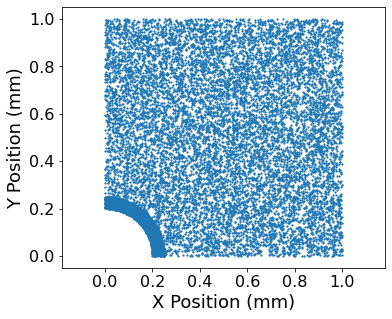

In [11]:
plot_pos(Xf)

In [ ]:
start_time = time.time()
# Construct neural network
# optimizer
nepoches = 3000
learning_rate = 1.0e-4
optimizer = torch.optim.Adam(list(Net_u.parameters())+list(Net_v.parameters()), lr=learning_rate)

for epoch in range(nepoches):
    ## Calculate loss
    
    loss1 = PDE(Xf, Net_u, func_u, Net_v, func_v)
    loss2 = BCx(Xb1, Net_u, func_u, Net_v, func_v)
    loss3 = BCy(Xb2, Net_u, func_u, Net_v, func_v)
    loss4 = BCc(Xb3, Net_u, func_u, Net_v, func_v)
    #loss = 50*loss1 + 2*loss2 + loss3 + 5*loss4
    loss = loss1 + loss2 + loss3 + loss4

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    
    if (epoch+1) % 100 == 0:
        Xb1, Xb2, Xb3, Xf = train_data2(Nx, Ny, Nc, Nf1, Nf2)

    if (epoch+1) % 100 == 0:
        print(f'epoch:{epoch+1}: total loss:{loss:.4e}, PDE:{loss1:.4e}, BC1:{loss2:.4e} BC2:{loss3:.4e}, BC3: {loss4:.4e}')
elapsed_time = time.time() - start_time
print(elapsed_time)

## Post-processing

In [19]:
import pandas as pd

In [20]:
data = pd.read_csv('CH-R2.csv')
X_train = data.iloc[:, 5:7].to_numpy()
U = data.iloc[:,11:13].to_numpy()
LE = data.iloc[:,13:16].to_numpy()
sig = data.iloc[:,16:19].to_numpy()
U1 = U[:,0].reshape(-1, 1)
U2 = U[:,1].reshape(-1, 1)
eps11 = LE[:,0].reshape(-1, 1)
eps22 = LE[:,1].reshape(-1, 1)
eps12 = LE[:,2].reshape(-1, 1)
sig11 = sig[:,0].reshape(-1, 1)
sig22 = sig[:,1].reshape(-1, 1)
sig12 = sig[:,2].reshape(-1, 1)

In [21]:
X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
X_train = X_train/10
U = torch.tensor(U, dtype=torch.float32)
U = U / 10

In [22]:
u1 = Net_u(X_train)*func_u(X_train).view(-1,1)
u2 = Net_v(X_train)*func_v(X_train).view(-1,1)

u1 = u1.detach().numpy().reshape(-1,1)*10
u2 = u2.detach().numpy().reshape(-1,1)*10

X = X_train[:,0].detach().numpy().reshape(-1,1)*10
Y = X_train[:,1].detach().numpy().reshape(-1,1)*10

In [26]:
r2_score(U1.reshape(-1,1), u1.reshape(-1,1))

-0.4734137250228574

In [73]:
max(u1)

array([0.14030337], dtype=float32)

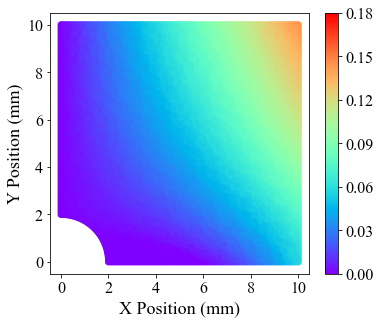

In [27]:
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
surf = ax.scatter(X, Y, c = u1, vmin=0, vmax=0.18, cmap=cm.rainbow)
#cbar = fig.colorbar(ax)
cb = fig.colorbar(surf, ticks=[0,0.03,0.06,0.09,0.12,0.15,0.18])
#cb.ax.locator_params(nbins=7)
cb.ax.tick_params(labelsize=16)
#cb.set_label(label =r'$\sigma_xx (MPa)$', fontsize=16)
#cb.set_label(fontsize=16)
ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)
for tick in ax.get_xticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
#plt.savefig('Flat-U-PED-5-5.png', dpi=600, transparent=True)
plt.show()

In [50]:
min(sig_x)

tensor([-0.0736], grad_fn=<SelectBackward>)

In [106]:
_, du_x, du_y,= derivativs2(X_train, Net_u, func_u)
_, dv_x, dv_y,= derivativs2(X_train, Net_v, func_v)

E, mu = 70, 0.3
sig_x = (du_x + mu*dv_y)*E/(1 - mu**2) 
sig_y = (dv_y + mu*du_x)*E/(1 - mu**2)
sig_xy = (dv_x + du_y)*E/(1 + mu)/2.

#X = Xf[:,0].detach().numpy().reshape(-1,1)
#Y = Xf[:,1].detach().numpy().reshape(-1,1)

sig_x = sig_x.detach().numpy()
sig_y = sig_y.detach().numpy() 
sig_xy = sig_xy.detach().numpy()

#err = abs(sig_x - sig11)

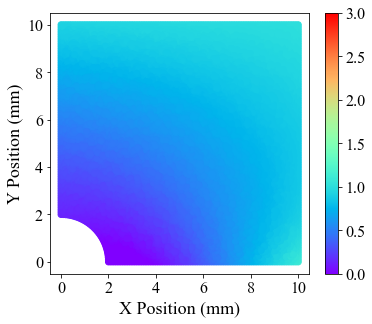

In [107]:
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
surf = ax.scatter(X, Y, c = sig_x, vmin=0, vmax=3.0, cmap=cm.rainbow)
#cbar = fig.colorbar(ax)
cb = fig.colorbar(surf)
cb.ax.locator_params(nbins=7)
cb.ax.tick_params(labelsize=16)
#cb.set_label(label =r'$\sigma_xx (MPa)$', fontsize=16)
#cb.set_label(fontsize=16)
ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)
for tick in ax.get_xticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
#plt.savefig('CH-R2-S-PDE-5-5-w1-1-1.png', dpi=600, transparent=True)
plt.show()

In [ ]:
data_out = np.hstack([X.reshape(-1,1),Y.reshape(-1,1),u1,u2,sig_x,sig_y,sig_xy])
df_out = pd.DataFrame(data_out, columns=['X', 'Y', 'U', 'V', 'Sig_x', 'Sig_y', 'Sig_xy'])

In [ ]:
df_out.to_csv('CH-R2-Energy-5-5.csv')